### Spark notebook ###

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

**Steps**

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.app.name,kda115 (jupyter)
spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.driver.memory,4g
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.executor.cores,2
spark.ui.port,4993
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.app.startTime,1726369066396


In [3]:
# Import the pyspark API to defined data types
from pyspark.sql import functions as F
from pyspark.sql.types import *

## Read Daily Data

In [4]:
# Reload the daily schema 
schema_daily = StructType([
    StructField("Station_ID", StringType(), False),
    StructField("DATE",  StringType(), True),
    StructField("Element", StringType(), True),
    StructField("VALUE", IntegerType(), True),
    StructField("Measurement_Flag", StringType(), True),
    StructField("Quality_Flag", StringType(), True),
    StructField("Source_Flag", StringType(), True),
    StructField("Observation_Time", StringType(), True)
])

In [5]:
# Read the daily data from HDFS
daily_data = (spark.read.format('csv').
         option('header', False).
         option('inferSchema', False).
         schema(schema_daily).
         load('hdfs:///data/ghcnd/daily')) 

# Show the result
daily_data.printSchema()
show_as_html(daily_data, 10)

root
 |-- Station_ID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- Element: string (nullable = true)
 |-- VALUE: integer (nullable = true)
 |-- Measurement_Flag: string (nullable = true)
 |-- Quality_Flag: string (nullable = true)
 |-- Source_Flag: string (nullable = true)
 |-- Observation_Time: string (nullable = true)



,Station_ID,DATE,Element,VALUE,Measurement_Flag,Quality_Flag,Source_Flag,Observation_Time
0,AE000041196,20100101,TMAX,259,None,None,S,None
1,AE000041196,20100101,TMIN,120,None,None,S,None
2,AE000041196,20100101,TAVG,181,H,None,S,None
3,AEM00041194,20100101,TMAX,250,None,None,S,None
4,AEM00041194,20100101,TMIN,168,None,None,S,None
5,AEM00041194,20100101,PRCP,0,None,None,S,None
6,AEM00041194,20100101,TAVG,194,H,None,S,None
7,AEM00041217,20100101,TMAX,250,None,None,S,None
8,AEM00041217,20100101,TMIN,146,None,None,S,None
9,AEM00041217,20100101,TAVG,199,H,None,S,None


## Read the Metadata 

### 1. Stations 

In [6]:
# Read the "station" data as text file 
stations_raw = spark.read.text("hdfs:///data/ghcnd/ghcnd-stations.txt")

In [7]:
# Extract columns using substring based on fixed - width
stations = stations_raw.select(
    F.trim(F.substring(stations_raw.value, 1, 11)).alias("Station_ID"),
    F.trim(F.substring(stations_raw.value, 13, 8)).alias("Latitude"),
    F.trim(F.substring(stations_raw.value, 22, 9)).alias("Longitude"),
    F.trim(F.substring(stations_raw.value, 32, 6)).alias("Elevation"),
    F.trim(F.substring(stations_raw.value, 39, 2)).alias("State_Code"),
    F.trim(F.substring(stations_raw.value, 42, 30)).alias("Station_Name"),
    F.trim(F.substring(stations_raw.value, 73, 3)).alias("GSN_Flag"),
    F.trim(F.substring(stations_raw.value, 77, 3)).alias("HCN_CRN_Flag"),
    F.trim(F.substring(stations_raw.value, 81, 5)).alias("WMO_ID")
)

In [8]:
# Convert the station dataset into appropriate data type 
stations = stations.select(
    F.col("Station_ID").cast('string'),
    F.col("Latitude").cast("double"),
    F.col("Longitude").cast("double"),
    F.col("Elevation").cast("double"),
    F.col("State_Code").cast("string"),
    F.col("Station_Name").cast("string"),
    F.col("GSN_Flag").cast("string"),
    F.col("HCN_CRN_Flag").cast("string"),
    F.col("WMO_ID").cast("string")
)

# Show the schema
stations.printSchema()

# Show the output 
show_as_html(stations, 20)

root
 |-- Station_ID: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Elevation: double (nullable = true)
 |-- State_Code: string (nullable = true)
 |-- Station_Name: string (nullable = true)
 |-- GSN_Flag: string (nullable = true)
 |-- HCN_CRN_Flag: string (nullable = true)
 |-- WMO_ID: string (nullable = true)



,Station_ID,Latitude,Longitude,Elevation,State_Code,Station_Name,GSN_Flag,HCN_CRN_Flag,WMO_ID
0,ACW00011604,17.1167,-61.7833,10.1,,ST JOHNS COOLIDGE FLD,,,
1,ACW00011647,17.1333,-61.7833,19.2,,ST JOHNS,,,
2,AE000041196,25.3330,55.5170,34.0,,SHARJAH INTER. AIRP,GSN,,41196
3,AEM00041194,25.2550,55.3640,10.4,,DUBAI INTL,,,41194
4,AEM00041217,24.4330,54.6510,26.8,,ABU DHABI INTL,,,41217
5,AEM00041218,24.2620,55.6090,264.9,,AL AIN INTL,,,41218
6,AF000040930,35.3170,69.0170,3366.0,,NORTH-SALANG,GSN,,40930
7,AFM00040938,34.2100,62.2280,977.2,,HERAT,,,40938
8,AFM00040948,34.5660,69.2120,1791.3,,KABUL INTL,,,40948
9,AFM00040990,31.5000,65.8500,1010.0,,KANDAHAR AIRPORT,,,40990


### 2. Countries 

In [9]:
# Read the "countries" data as textfile 
countries_raw = spark.read.text("hdfs:///data/ghcnd/ghcnd-countries.txt")

# Transform unstructured 'ghcnd_countries' string into separate string columns
countries = countries_raw.select(
    F.trim(F.substring(countries_raw.value, 1, 2)).alias("code_country"),
    F.trim(F.substring(countries_raw.value, 4, 61)).alias("Country_Name")
)



### 3. Inventory

In [10]:
# Read the "inventory" data as textfile 
inventory_raw = spark.read.text("hdfs:///data/ghcnd/ghcnd-inventory.txt")

# Transform unstructured 'ghcnd_inventory' string into separate string columns
inventory = inventory_raw.select(
    F.trim(F.substring(inventory_raw.value, 1, 11)).alias("Station_ID"),
    F.trim(F.substring(inventory_raw.value, 13, 6)).alias("Latitude"),
    F.trim(F.substring(inventory_raw.value, 22, 9)).alias("Longitude"),
    F.trim(F.substring(inventory_raw.value, 32, 4)).alias("Element"),
    F.trim(F.substring(inventory_raw.value, 37, 4)).alias("First_Year"),
    F.trim(F.substring(inventory_raw.value, 42, 4)).alias("Last_Year")
)

# Convert the inventory dataset into appropriate data type 
inventory = inventory.select(
    F.col("Station_ID").cast("string"),
    F.col("Latitude").cast("double"),
    F.col("Longitude").cast("double"),
    F.col("Element").cast("string"),
    F.col("First_Year").cast("integer"),
    F.col("Last_Year").cast("integer")
)

### 4. States

In [14]:
# Read the "state" data as textfile 
state_raw = spark.read.text("hdfs:///data/ghcnd/ghcnd-states.txt")

# Show the outpout and schema
state_raw.printSchema()
show_as_html(state_raw,20)

root
 |-- value: string (nullable = true)



,value
0,AB ALBERTA
1,AK ALASKA
2,AL ALABAMA ...
3,AR ARKANSAS
4,AS AMERICAN SAMOA
5,AZ ARIZONA
6,BC BRITISH COLUMBIA
7,CA CALIFORNIA
8,CO COLORADO
9,CT CONNECTICUT


In [15]:
# Transform unstructured 'ghcnd_states' string into separate string columns
states = state_raw.select(
    F.trim(F.substring(state_raw.value, 1, 2)).alias("code_state"),
    F.trim(F.substring(state_raw.value, 4, 47)).alias("State_Name")
)

# Show the schema and output 
states.printSchema()
show_as_html(states, 20)

root
 |-- code_state: string (nullable = true)
 |-- State_Name: string (nullable = true)



,code_state,State_Name
0,AB,ALBERTA
1,AK,ALASKA
2,AL,ALABAMA
3,AR,ARKANSAS
4,AS,AMERICAN SAMOA
5,AZ,ARIZONA
6,BC,BRITISH COLUMBIA
7,CA,CALIFORNIA
8,CO,COLORADO
9,CT,CONNECTICUT


## Stations Processing

### Question 01

#### A. Extract the 2 character country code from each station code in stations and store the output as a new column

In [11]:
# Extract the 2 character country code from each station using "WithColumn"
stations = stations.withColumn("COUNTRY_CODE", F.substring("Station_ID", 1, 2))

# Show the updated DataFrame 
show_as_html(stations, 20)

,Station_ID,Latitude,Longitude,Elevation,State_Code,Station_Name,GSN_Flag,HCN_CRN_Flag,WMO_ID,COUNTRY_CODE
0,ACW00011604,17.1167,-61.7833,10.1,,ST JOHNS COOLIDGE FLD,,,,AC
1,ACW00011647,17.1333,-61.7833,19.2,,ST JOHNS,,,,AC
2,AE000041196,25.3330,55.5170,34.0,,SHARJAH INTER. AIRP,GSN,,41196,AE
3,AEM00041194,25.2550,55.3640,10.4,,DUBAI INTL,,,41194,AE
4,AEM00041217,24.4330,54.6510,26.8,,ABU DHABI INTL,,,41217,AE
5,AEM00041218,24.2620,55.6090,264.9,,AL AIN INTL,,,41218,AE
6,AF000040930,35.3170,69.0170,3366.0,,NORTH-SALANG,GSN,,40930,AF
7,AFM00040938,34.2100,62.2280,977.2,,HERAT,,,40938,AF
8,AFM00040948,34.5660,69.2120,1791.3,,KABUL INTL,,,40948,AF
9,AFM00040990,31.5000,65.8500,1010.0,,KANDAHAR AIRPORT,,,40990,AF


#### B. LEFT JOIN "stations" with "countries"

In [12]:
# Left Join the stations with countries table based on countries_code 
stations_enriched = stations.join(countries, stations.COUNTRY_CODE == countries.code_country, how = "left")

# Show the output 
show_as_html(stations_enriched,20)

,Station_ID,Latitude,Longitude,Elevation,State_Code,Station_Name,GSN_Flag,HCN_CRN_Flag,WMO_ID,COUNTRY_CODE,code_country,Country_Name
0,ACW00011604,17.1167,-61.7833,10.1,,ST JOHNS COOLIDGE FLD,,,,AC,AC,Antigua and Barbuda
1,ACW00011647,17.1333,-61.7833,19.2,,ST JOHNS,,,,AC,AC,Antigua and Barbuda
2,AE000041196,25.3330,55.5170,34.0,,SHARJAH INTER. AIRP,GSN,,41196,AE,AE,United Arab Emirates
3,AEM00041194,25.2550,55.3640,10.4,,DUBAI INTL,,,41194,AE,AE,United Arab Emirates
4,AEM00041217,24.4330,54.6510,26.8,,ABU DHABI INTL,,,41217,AE,AE,United Arab Emirates
5,AEM00041218,24.2620,55.6090,264.9,,AL AIN INTL,,,41218,AE,AE,United Arab Emirates
6,AF000040930,35.3170,69.0170,3366.0,,NORTH-SALANG,GSN,,40930,AF,AF,Afghanistan
7,AFM00040938,34.2100,62.2280,977.2,,HERAT,,,40938,AF,AF,Afghanistan
8,AFM00040948,34.5660,69.2120,1791.3,,KABUL INTL,,,40948,AF,AF,Afghanistan
9,AFM00040990,31.5000,65.8500,1010.0,,KANDAHAR AIRPORT,,,40990,AF,AF,Afghanistan


#### C. LEFT JOIN "stations" with "states"

In [16]:
# Left Join the stations with states table based on countries_code
# Since state codes are only available for US stations, we will need to allow the cases where states are missing 
stations_enriched = stations_enriched.join(states, stations_enriched.State_Code == states.code_state, how = "left")

# Show the output 
show_as_html(stations_enriched,20)

,Station_ID,Latitude,Longitude,Elevation,State_Code,Station_Name,GSN_Flag,HCN_CRN_Flag,WMO_ID,COUNTRY_CODE,code_country,Country_Name,code_state,State_Name
0,ACW00011604,17.1167,-61.7833,10.1,,ST JOHNS COOLIDGE FLD,,,,AC,AC,Antigua and Barbuda,None,None
1,ACW00011647,17.1333,-61.7833,19.2,,ST JOHNS,,,,AC,AC,Antigua and Barbuda,None,None
2,AE000041196,25.3330,55.5170,34.0,,SHARJAH INTER. AIRP,GSN,,41196,AE,AE,United Arab Emirates,None,None
3,AEM00041194,25.2550,55.3640,10.4,,DUBAI INTL,,,41194,AE,AE,United Arab Emirates,None,None
4,AEM00041217,24.4330,54.6510,26.8,,ABU DHABI INTL,,,41217,AE,AE,United Arab Emirates,None,None
5,AEM00041218,24.2620,55.6090,264.9,,AL AIN INTL,,,41218,AE,AE,United Arab Emirates,None,None
6,AF000040930,35.3170,69.0170,3366.0,,NORTH-SALANG,GSN,,40930,AF,AF,Afghanistan,None,None
7,AFM00040938,34.2100,62.2280,977.2,,HERAT,,,40938,AF,AF,Afghanistan,None,None
8,AFM00040948,34.5660,69.2120,1791.3,,KABUL INTL,,,40948,AF,AF,Afghanistan,None,None
9,AFM00040990,31.5000,65.8500,1010.0,,KANDAHAR AIRPORT,,,40990,AF,AF,Afghanistan,None,None


#### D. Based on inventory, what was the first and last year each stations was active and collected any element at all?

In [17]:
# Determine the first and last year each station was active by analyzing the inventory data 
station_year = inventory.groupBy("Station_ID").agg(
    F.min("First_Year").alias("First_Year"),
    F.max("Last_Year").alias("Last_Year")
)

# Show the result
show_as_html(station_year, 20)

,Station_ID,First_Year,Last_Year
0,CA007018000,1902,2004
1,CA00701A9E0,1974,1982
2,CA007025212,1978,1989
3,CA007027040,1937,1990
4,CA007027656,1965,2024
5,CA007028700,1963,2024
6,CA00702HBHA,1973,1981
7,CA007030462,1941,1967
8,CA007033120,1933,1972
9,CA007034010,1974,1994


In [18]:
# Calculate the length of time (in years) each station was active
station_year = station_year.withColumn(
    "Total_Years_Active", 
    (F.col("Last_Year") - F.col("First_Year") + 1)
)

# show the result 
# Show the result with the station that have minimum Years_Active
show_as_html(station_year.sort("Total_Years_Active",ascending = True), 5)

,Station_ID,First_Year,Last_Year,Total_Years_Active
0,US1FLDV0086,2018,2018,1
1,US1ILFL0010,2015,2015,1
2,US1FLVL0069,2018,2018,1
3,US1COLR0205,2000,2000,1
4,US1HIHN0017,2014,2014,1


In [19]:
# Show the result with the station that have maximum Years_Active
show_as_html(station_year.sort("Total_Years_Active",ascending = False), 5)

,Station_ID,First_Year,Last_Year,Total_Years_Active
0,ASN00078015,1750,2024,275
1,ASN00009021,1750,2024,275
2,ASN00003003,1750,2024,275
3,ASN00033119,1750,2024,275
4,ASN00090015,1750,2024,275


In [20]:
# Find the minimum/maximum value in the Years_Active column
min_years_active = station_year.agg(F.min("Total_Years_Active")).first()[0]
max_years_active = station_year.agg(F.max("Total_Years_Active")).first()[0]

# Filter the DataFrame to get stations with the minimum/maximum Years_Active
stations_with_min_years_active = station_year.filter(F.col("Total_Years_Active") == min_years_active)
stations_with_max_years_active = station_year.filter(F.col("Total_Years_Active") == max_years_active)


# Count how many stations have the minimum/maximum Years_Active
count_min_years_active = stations_with_min_years_active.count()
count_max_years_active = stations_with_max_years_active.count()

# Display the result
print(f"The number of stations with the minimum Years_Active ({min_years_active} years) is: {count_min_years_active}")
print(f"The number of stations with the maximum Years_Active ({max_years_active} years) is: {count_max_years_active}")

The number of stations with the minimum Years_Active (1 years) is: 2701
The number of stations with the maximum Years_Active (275 years) is: 64


In [21]:
# Calculate the average Years_Active
average_years_active = station_year.agg(F.avg("Total_Years_Active")).first()[0]

# Display the result
print(f"The average Years_Active across all stations is: {average_years_active:.2f} years")

The average Years_Active across all stations is: 34.98 years


Explanation: The analysis of station activity reveals that the majority of stations have a short operational lifespan, there are 2,701 stations active for only 1 year while 64 stations have been active for up to 275 years which from 1750 to 2024. On average, stations remain active for approximately 35 years

#### D.2 How many different elements has each station collected overall?

In order to know hor many different elements each station collect, we need to count how many different elements each station has collected over time.

In [22]:
# Count distinct elements for each station 
# We use the count distinct to remove the duplicate element 
station_elements_count = inventory.groupBy("Station_ID").agg(
    F.countDistinct("Element").alias("number_elements")
)

# Show the result 
show_as_html(station_elements_count,10)

,Station_ID,number_elements
0,US1COHF0004,7
1,US1COJF0361,6
2,US1COJF0537,3
3,US1COLP0061,7
4,US1COLR0033,7
5,US1COLR0215,5
6,US1COLR0308,6
7,US1COLR0435,3
8,US1COLR0645,7
9,US1COLR1290,6


#### D.3 Count seperate number of core elements and the number of "other" elements that each station has collected overall

In [23]:
# List out the 5 core elements 
core_elements = ["PRCP","SNOW","SNWD","TMAX","TMIN"]

In [24]:
# Add columns to classify core and other elements
elements = (inventory.
            withColumn('Core_Element_Type', F.when(F.col('ELEMENT').isin(core_elements), 1).otherwise(0)).
            withColumn('Other_Element_Type', F.when(~F.col('ELEMENT').isin(core_elements), 1).otherwise(0))
           )

# print the result 
show_as_html(elements, 10)

,Station_ID,Latitude,Longitude,Element,First_Year,Last_Year,Core_Element_Type,Other_Element_Type
0,ACW00011604,17.11,-61.7833,TMAX,1949,1949,1,0
1,ACW00011604,17.11,-61.7833,TMIN,1949,1949,1,0
2,ACW00011604,17.11,-61.7833,PRCP,1949,1949,1,0
3,ACW00011604,17.11,-61.7833,SNOW,1949,1949,1,0
4,ACW00011604,17.11,-61.7833,SNWD,1949,1949,1,0
5,ACW00011604,17.11,-61.7833,PGTM,1949,1949,0,1
6,ACW00011604,17.11,-61.7833,WDFG,1949,1949,0,1
7,ACW00011604,17.11,-61.7833,WSFG,1949,1949,0,1
8,ACW00011604,17.11,-61.7833,WT03,1949,1949,0,1
9,ACW00011604,17.11,-61.7833,WT08,1949,1949,0,1


In [25]:
# Aggregate data to get element counts
element_counts = (
    elements.groupBy("Station_ID")
    .agg(
        F.countDistinct("Element").cast('integer').alias("Total_Unique_Elements"),
        F.sum("Core_Element_Type").cast('integer').alias("Core_Element_Count"),
        F.sum("Other_Element_Type").cast('integer').alias("Other_Element_Count")
    )
)

# show the result 
show_as_html(element_counts.sort("Total_Unique_Elements",ascending = False), 10)

,Station_ID,Total_Unique_Elements,Core_Element_Count,Other_Element_Count
0,USW00013880,70,5,65
1,USW00014607,70,5,65
2,USW00023066,67,5,62
3,USW00013958,66,5,61
4,USW00093817,65,5,60
5,USW00024121,65,5,60
6,USW00093058,64,5,59
7,USW00014944,64,5,59
8,USW00024156,63,5,58
9,USW00024157,63,5,58


In [26]:
# Combine with first and last year data based on ID
element_counts = station_year.join(element_counts, "Station_ID", "inner")


# Show the combined DataFrame
show_as_html(element_counts.sort("Total_Unique_Elements",ascending = False), 10)

,Station_ID,First_Year,Last_Year,Total_Years_Active,Total_Unique_Elements,Core_Element_Count,Other_Element_Count
0,USW00013880,1937,2024,88,70,5,65
1,USW00014607,1939,2024,86,70,5,65
2,USW00023066,1900,2024,125,67,5,62
3,USW00013958,1938,2024,87,66,5,61
4,USW00024121,1888,2024,137,65,5,60
5,USW00093817,1948,2024,77,65,5,60
6,USW00093058,1942,2024,83,64,5,59
7,USW00014944,1932,2024,93,64,5,59
8,USW00024157,1889,2024,136,63,5,58
9,USW00024127,1941,2024,84,63,5,58


In [27]:
# How many unique element that each station collect most ?
# Calculate the average number of total unique elements collected by each station
average_unique_elements = element_counts.agg(F.avg("Total_Unique_Elements")).first()[0]

# Display the result
print(f"The average number of total unique elements collected by each station is: {average_unique_elements:.2f}")


# Calculate the minimum number of unique elements collected by any station
min_unique_elements = element_counts.agg(F.min("Total_Unique_Elements")).first()[0]

# Filter the DataFrame to count how many stations have this minimum number of unique elements
stations_with_min_unique_elements = element_counts.filter(F.col("Total_Unique_Elements") == min_unique_elements).count()

# Display the result
print(f"The number of stations with the minimum unique elements ({min_unique_elements}) is: {stations_with_min_unique_elements}")

The average number of total unique elements collected by each station is: 5.91
The number of stations with the minimum unique elements (1) is: 16390


In [28]:
# Count the number of stations that don't have any Core_Element_Count (i.e., Core_Element_Count is 0)
no_core_element_count = element_counts.filter(F.col('Core_Element_Count') == 0).count()
one_core_element_count = element_counts.filter(F.col('Core_Element_Count') == 1).count()
two_core_element_count = element_counts.filter(F.col('Core_Element_Count') == 2).count()
three_core_element_count = element_counts.filter(F.col('Core_Element_Count') == 3).count()
fourth_core_element_count = element_counts.filter(F.col('Core_Element_Count') == 4).count()

# Display the result
print(f"The number of stations with no Core_Element_Count is: {no_core_element_count}")
print(f"The number of stations with one Core_Element_Count is: {one_core_element_count}")
print(f"The number of stations with two Core_Element_Count is: {two_core_element_count}")
print(f"The number of stations with three Core_Element_Count is: {three_core_element_count}")
print(f"The number of stations with fourth Core_Element_Count is: {fourth_core_element_count}")

The number of stations with no Core_Element_Count is: 48
The number of stations with one Core_Element_Count is: 29706
The number of stations with two Core_Element_Count is: 21853
The number of stations with three Core_Element_Count is: 47752
The number of stations with fourth Core_Element_Count is: 8143


There are two stations "USW00014607" and "USW00013880" that have the 70 unique element which consider as the highest unique element

### Plot the number of Stations coresspond to the number of Elements collected

In [29]:
# Count the number of stations collecting different numbers of unique elements
elements_stations_collected = (
    daily_data
    .groupby(F.col("Station_ID"))
    .agg(
        F.size(F.collect_set(F.col("Element"))).alias("Number_OF_Elements")
    )
    .groupby(F.col("Number_OF_Elements"))
    .agg(
        F.count(F.col("Station_ID")).alias("Number_OF_Stations")
    )
    .orderBy(F.col("Number_OF_Stations").desc())
)

# Show the result 
show_as_html(elements_stations_collected, 5)

,Number_OF_Elements,Number_OF_Stations
0,4,27867
1,7,20036
2,1,16356
3,5,14565
4,3,12258


In [30]:
# Convert the Spark DataFrame to pandas DataFrame
elements_stations_collected = elements_stations_collected.toPandas()

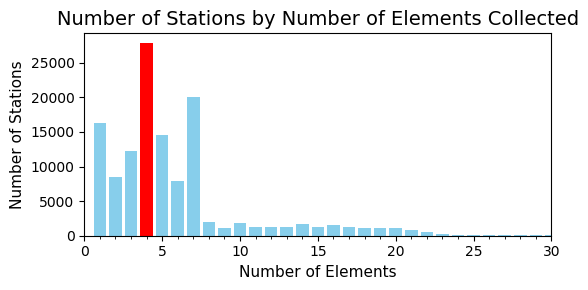

In [33]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Identify the maximum value in the 'Number_OF_Stations' column
max_value = elements_stations_collected['Number_OF_Stations'].max()

# Create a bar plot using the pandas DataFrame
plt.figure(figsize=(6, 3), dpi=100)

# Plot all bars in blue, highlight the highest one in red
colors = ['red' if val == max_value else 'skyblue' for val in elements_stations_collected['Number_OF_Stations']]
plt.bar(elements_stations_collected['Number_OF_Elements'], 
        elements_stations_collected['Number_OF_Stations'], 
        color=colors)

# Add titles and labels
plt.title('Number of Stations by Number of Elements Collected', fontsize=14)
plt.xlabel('Number of Elements', fontsize=11)
plt.ylabel('Number of Stations', fontsize=11)

# Adjust x-axis ticks to display every 5 elements and ensure integer ticks
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))  # Set ticks every 5 units
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Add minor ticks

# Set the x-axis limit to 30
plt.xlim(0, 30)

# Show the plot
plt.tight_layout()
# Save the plot as a PNG file
# plt.savefig('Stations_By_Elements_Collected.png', dpi = 300, bbox_inches='tight')
plt.show()

#### D.4 How many stations collect all five core elements?

In [34]:
element_counts.filter(F.col('Core_Element_Count') == 5).count()

20482

#### D.5 How many stations collect only precipitation and no other elements?

In [35]:
# Group by station ID and collect the set of unique elements collected
station_elements = (
    inventory.groupBy("Station_ID")
    .agg(F.collect_set("ELEMENT").alias("Elements_Set"))
)

show_as_html(station_elements, 5)

,Station_ID,Elements_Set
0,AGE00147719,"[TMAX, TMIN, PRCP, TAVG]"
1,ALE00100939,"[TMAX, PRCP]"
2,AQC00914873,"[WT03, TMAX, TMIN, PRCP, SNWD, MDPR, DAPR, SNO..."
3,AR000000002,[PRCP]
4,AR000875850,"[TMAX, TMIN, PRCP, SNWD, TAVG]"


In [36]:
# Filter stations where the only element collected is 'PRCP'
stations_with_only_prcp = station_elements.filter(
    (F.size("Elements_Set") == 1) & (F.array_contains("Elements_Set", "PRCP"))
)

# Count the number of such stations
num_stations_with_only_prcp = stations_with_only_prcp.count()

# Show the result
print(f"Number of stations that collect only precipitation (PRCP) and no other elements: {num_stations_with_only_prcp} staions")

Number of stations that collect only precipitation (PRCP) and no other elements: 16308 staions


#### E. Left Join stations and your output from step (d)

In [37]:
# Left Join stations and output from (d)
enriched_stations = stations_enriched.join(element_counts, "Station_ID", how = 'left')

# Show the result
show_as_html(enriched_stations, 5)

,Station_ID,Latitude,Longitude,Elevation,State_Code,Station_Name,GSN_Flag,HCN_CRN_Flag,WMO_ID,COUNTRY_CODE,code_country,Country_Name,code_state,State_Name,First_Year,Last_Year,Total_Years_Active,Total_Unique_Elements,Core_Element_Count,Other_Element_Count
0,AGE00147719,33.7997,2.8900,767.0,,LAGHOUAT,,,60545,AG,AG,Algeria,None,None,1888,2024,137,4,3,1
1,ALE00100939,41.3331,19.7831,89.0,,TIRANA,,,,AL,AL,Albania,None,None,1940,2000,61,2,2,0
2,AQC00914873,-14.3500,-170.7667,14.9,AS,TAPUTIMU TUTUILA,,,,AQ,AQ,American Samoa [United States],AS,AMERICAN SAMOA,1955,1967,13,12,5,7
3,AR000000002,-29.8200,-57.4200,75.0,,BONPLAND,,,,AR,AR,Argentina,None,None,1981,2000,20,1,1,0
4,AR000875850,-34.5830,-58.4830,25.0,,BUENOS AIRES OBSERV,,,87585,AR,AR,Argentina,None,None,1908,2024,117,5,4,1


In [38]:
# Check the schema of the enriched_stations
enriched_stations.printSchema()

root
 |-- Station_ID: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Elevation: double (nullable = true)
 |-- State_Code: string (nullable = true)
 |-- Station_Name: string (nullable = true)
 |-- GSN_Flag: string (nullable = true)
 |-- HCN_CRN_Flag: string (nullable = true)
 |-- WMO_ID: string (nullable = true)
 |-- COUNTRY_CODE: string (nullable = true)
 |-- code_country: string (nullable = true)
 |-- Country_Name: string (nullable = true)
 |-- code_state: string (nullable = true)
 |-- State_Name: string (nullable = true)
 |-- First_Year: integer (nullable = true)
 |-- Last_Year: integer (nullable = true)
 |-- Total_Years_Active: integer (nullable = true)
 |-- Total_Unique_Elements: integer (nullable = true)
 |-- Core_Element_Count: integer (nullable = true)
 |-- Other_Element_Count: integer (nullable = true)



In [39]:
# Drop 2 duplicate columns in the enriched_stations before saving to HDFS
enriched_stations = enriched_stations.drop('code_country', 'State_Code')

# Show the result
show_as_html(enriched_stations, 5)

,Station_ID,Latitude,Longitude,Elevation,Station_Name,GSN_Flag,HCN_CRN_Flag,WMO_ID,COUNTRY_CODE,Country_Name,code_state,State_Name,First_Year,Last_Year,Total_Years_Active,Total_Unique_Elements,Core_Element_Count,Other_Element_Count
0,AGE00147719,33.7997,2.8900,767.0,LAGHOUAT,,,60545,AG,Algeria,None,None,1888,2024,137,4,3,1
1,ALE00100939,41.3331,19.7831,89.0,TIRANA,,,,AL,Albania,None,None,1940,2000,61,2,2,0
2,AQC00914873,-14.3500,-170.7667,14.9,TAPUTIMU TUTUILA,,,,AQ,American Samoa [United States],AS,AMERICAN SAMOA,1955,1967,13,12,5,7
3,AR000000002,-29.8200,-57.4200,75.0,BONPLAND,,,,AR,Argentina,None,None,1981,2000,20,1,1,0
4,AR000875850,-34.5830,-58.4830,25.0,BUENOS AIRES OBSERV,,,87585,AR,Argentina,None,None,1908,2024,117,5,4,1


In [40]:
# Rename the code_state for more readable 
enriched_stations = (
    enriched_stations
    .withColumnRenamed('code_state', 'State_Code')
)

# Show the result
show_as_html(enriched_stations, 5)

,Station_ID,Latitude,Longitude,Elevation,Station_Name,GSN_Flag,HCN_CRN_Flag,WMO_ID,COUNTRY_CODE,Country_Name,State_Code,State_Name,First_Year,Last_Year,Total_Years_Active,Total_Unique_Elements,Core_Element_Count,Other_Element_Count
0,AGE00147719,33.7997,2.8900,767.0,LAGHOUAT,,,60545,AG,Algeria,None,None,1888,2024,137,4,3,1
1,ALE00100939,41.3331,19.7831,89.0,TIRANA,,,,AL,Albania,None,None,1940,2000,61,2,2,0
2,AQC00914873,-14.3500,-170.7667,14.9,TAPUTIMU TUTUILA,,,,AQ,American Samoa [United States],AS,AMERICAN SAMOA,1955,1967,13,12,5,7
3,AR000000002,-29.8200,-57.4200,75.0,BONPLAND,,,,AR,Argentina,None,None,1981,2000,20,1,1,0
4,AR000875850,-34.5830,-58.4830,25.0,BUENOS AIRES OBSERV,,,87585,AR,Argentina,None,None,1908,2024,117,5,4,1


In [41]:
# Check the schema of the enriched_stations
enriched_stations.printSchema()

root
 |-- Station_ID: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Elevation: double (nullable = true)
 |-- Station_Name: string (nullable = true)
 |-- GSN_Flag: string (nullable = true)
 |-- HCN_CRN_Flag: string (nullable = true)
 |-- WMO_ID: string (nullable = true)
 |-- COUNTRY_CODE: string (nullable = true)
 |-- Country_Name: string (nullable = true)
 |-- State_Code: string (nullable = true)
 |-- State_Name: string (nullable = true)
 |-- First_Year: integer (nullable = true)
 |-- Last_Year: integer (nullable = true)
 |-- Total_Years_Active: integer (nullable = true)
 |-- Total_Unique_Elements: integer (nullable = true)
 |-- Core_Element_Count: integer (nullable = true)
 |-- Other_Element_Count: integer (nullable = true)



In [ ]:
! hdfs dfs -ls "hdfs:///user/kda115/"

In [ ]:
# Save the enriched_stations as Parquet file
(enriched_stations.write.mode('overwrite')
 .parquet('hdfs:///user/kda115/ghcnd/result/enriched_stations.parquet'))

In [42]:
! hdfs dfs -ls "hdfs:///user/kda115/"

Found 2 items
drwxr-xr-x   - kda115 kda115          0 2024-08-28 15:04 hdfs:///user/kda115/ghcnd
drwxr-xr-x   - kda115 kda115          0 2024-07-25 14:08 hdfs:///user/kda115/helloworld


### Question 02

### A. Left Join 1000 rows subset of daily and your output from step e

In [43]:
# Load 1000 rows subset of daily 
daily_subset = (
    spark.read.format("csv")
    .option("header", False)
    .option("inferSchema", False)
    .schema(schema_daily)
    .load("hdfs:///data/ghcnd/daily")
    .limit(1000)
)

# Show the the result 
show_as_html(daily_subset, 10)

,Station_ID,DATE,Element,VALUE,Measurement_Flag,Quality_Flag,Source_Flag,Observation_Time
0,AE000041196,20100101,TMAX,259,None,None,S,NaT
1,AE000041196,20100101,TMIN,120,None,None,S,NaT
2,AE000041196,20100101,TAVG,181,H,None,S,NaT
3,AEM00041194,20100101,TMAX,250,None,None,S,NaT
4,AEM00041194,20100101,TMIN,168,None,None,S,NaT
5,AEM00041194,20100101,PRCP,0,None,None,S,NaT
6,AEM00041194,20100101,TAVG,194,H,None,S,NaT
7,AEM00041217,20100101,TMAX,250,None,None,S,NaT
8,AEM00041217,20100101,TMIN,146,None,None,S,NaT
9,AEM00041217,20100101,TAVG,199,H,None,S,NaT


In [44]:
# Left Join 1000 rows subset of daily into enriched_stations using Station_ID
station_daily_subset = daily_subset.join(enriched_stations, "Station_ID", how = 'left')

# show the result
show_as_html(station_daily_subset, 10)

,Station_ID,DATE,Element,VALUE,Measurement_Flag,Quality_Flag,Source_Flag,Observation_Time,Latitude,Longitude,...,COUNTRY_CODE,Country_Name,State_Code,State_Name,First_Year,Last_Year,Total_Years_Active,Total_Unique_Elements,Core_Element_Count,Other_Element_Count
0,AGE00147719,20090101,TAVG,87,H,None,S,NaT,33.7997,2.8900,...,AG,Algeria,None,None,1888,2024,137,4,3,1
1,ARM00087022,20090101,TMIN,234,None,None,S,NaT,-22.6200,-63.7940,...,AR,Argentina,None,None,1973,2024,52,4,3,1
2,ARM00087022,20090101,TAVG,263,H,None,S,NaT,-22.6200,-63.7940,...,AR,Argentina,None,None,1973,2024,52,4,3,1
3,ARM00087480,20090101,TMAX,271,None,None,S,NaT,-32.9040,-60.7850,...,AR,Argentina,None,None,1965,2024,60,5,4,1
4,ARM00087480,20090101,TMIN,38,None,None,S,NaT,-32.9040,-60.7850,...,AR,Argentina,None,None,1965,2024,60,5,4,1
5,ARM00087480,20090101,PRCP,8,None,None,S,NaT,-32.9040,-60.7850,...,AR,Argentina,None,None,1965,2024,60,5,4,1
6,ARM00087480,20090101,TAVG,192,H,None,S,NaT,-32.9040,-60.7850,...,AR,Argentina,None,None,1965,2024,60,5,4,1
7,ARM00087904,20090101,TMIN,96,None,None,S,NaT,-50.2670,-72.0500,...,AR,Argentina,None,None,2003,2024,22,5,4,1
8,ARM00087904,20090101,TAVG,156,H,None,S,NaT,-50.2670,-72.0500,...,AR,Argentina,None,None,2003,2024,22,5,4,1
9,ASN00005004,20090101,PRCP,0,None,None,a,NaT,-22.3761,114.1108,...,AS,Australia,None,None,1915,2022,108,4,1,3


#### A. 1 Are there any stations in your subset of daily that are not in stations?

In [45]:
# Check the stations in daily subset that are not in stations using left anti join 
missing_stations = daily_subset.join(enriched_stations, "Station_ID", how = "left_anti")

# Count the number of missing stations
missing_count = missing_stations.count()

# Show the result
print(f"Number of stations in daily subset that are not in stations: {missing_count}")

Number of stations in daily subset that are not in stations: 0


#### A. 2 How expensive do you think it would be to Left Join daily and stations?

In [46]:
enriched_stations.count()

127994

The daily dataset is extremely large, with over 3 billion rows, while the enriched_station is small which only contains 127,994 rows. In a LEFT JOIN, every rows from daily dataset must be checked against the enriched_stations, which means that the join operation needs to handle a massive volume of data. Spark often needs to shuffle data across the network to perform joins. Since the daily dataset is so large, this shuffling can become a major bottleneck, leading to increased latency and higher network I/O.

#### A. 3 Can you think a more efficient way?

A more efficient way to perform this operation would be to use a broadcast join. Since the enriched_stations dataset is small (127,994 rows), it can be broadcasted to all worker nodes in the cluster. This approach eliminates the need for shuffling the large daily dataset across the network. By broadcasting enriched_stations, each executor has a local copy of the smaller dataset, allowing for a fast and efficient join with the large daily dataset. This significantly reduces network I/O and computation time, making the operation much more scalable and performant.

### B. Count the number of stations in daily that are not in stations at all

In [47]:
# Load the daily dataset with the defined schema
daily_data = spark.read.csv("hdfs:///data/ghcnd/daily/", 
                            schema=schema_daily, 
                            header=False)

In [48]:
# Print out the number of partitions
num_partitions_2023 = daily_data.rdd.getNumPartitions()

print(f"Number of partitions: {num_partitions_2023}")

Number of partitions: 105


In [49]:
# Show the result 
show_as_html(daily_data, 10)

,Station_ID,DATE,Element,VALUE,Measurement_Flag,Quality_Flag,Source_Flag,Observation_Time
0,AE000041196,20100101,TMAX,259,None,None,S,NaT
1,AE000041196,20100101,TMIN,120,None,None,S,NaT
2,AE000041196,20100101,TAVG,181,H,None,S,NaT
3,AEM00041194,20100101,TMAX,250,None,None,S,NaT
4,AEM00041194,20100101,TMIN,168,None,None,S,NaT
5,AEM00041194,20100101,PRCP,0,None,None,S,NaT
6,AEM00041194,20100101,TAVG,194,H,None,S,NaT
7,AEM00041217,20100101,TMAX,250,None,None,S,NaT
8,AEM00041217,20100101,TMIN,146,None,None,S,NaT
9,AEM00041217,20100101,TAVG,199,H,None,S,NaT


In [50]:
# Count the number of rows in daily data 
daily_data_count = daily_data.count()

# Show the result 
print(f"Number of rows in daily dataset : {daily_data_count}")

Number of rows in daily dataset : 3119374043


In [51]:
# In order to save the computation resources, we use the broadcast join to perform the count 
# Broadcast the stations DataFrame
stations_broadcast = F.broadcast(enriched_stations)

# Perform an anti join to find station in daily that are not in stations 
missing_stations = daily_data.join(stations_broadcast, "Station_ID", how = "left_anti")

# Count the number of missing stations 
num_missing_stations = missing_stations.select("Station_ID").distinct().count()

# Show the result
print(f"Number of stations in daily that are not in stations: {num_missing_stations}")

Number of stations in daily that are not in stations: 0


In [52]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()